In [59]:
import emcee
from scipy.optimize import minimize
import corner
import ptemcee
import subprocess
import pandas as pd

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import run_simple_energy_loss

In [2]:
simulation=run_simple_energy_loss.run_simulation

In [3]:
pT_range = (1, 10, 10) # Compute more observable than needed to avoid boundry unstabilities.
pT_obs = [3, 5, 7] # p_T Observables we will use for the analysis

In [4]:
from emukit.core import ParameterSpace, ContinuousParameter

In [5]:
prior_ranges= {'alpha_s':(0.05,0.5), 'exponent_inel':(-3,3), 'exponent_el':(-3,3), 'scale_inel':(0.1, 0.5), 'scale_el':(0.1, 0.5)}
true_values= {'alpha_s': 0.2, 'exponent_inel': -1, 'exponent_el': 1, 'scale_inel': 0.3, 'scale_el': 0.3}
name_to_position =  {'alpha_s':0, 'exponent_inel':1, 'exponent_el':2, 'scale_inel':3, 'scale_el':4}

In [54]:
# We will generate observable for these model parametr values and consider them as experimental data
# We will generate observables for these model parameter values and consider them as experimental data
truth = np.array([true_values['alpha_s'],  true_values['exponent_inel'],
                 true_values['exponent_el'],true_values['scale_inel'],true_values['scale_el']]).reshape(1,-1)

Working on 1/1 design


/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


Text(0.5, 1.0, 'Experimental observations')

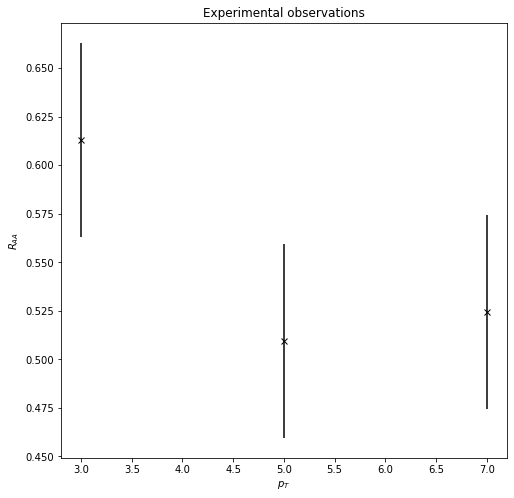

In [7]:
# Set seed for reproducibility.
seed = 42
np.random.seed(seed)

# Generate some synthetic data from the model.
x = np.array(pT_obs)
N = len(x)
obserr = 0.05 # Amplitude of noise term
obs = simulation(truth, *pT_range)[:,pT_obs] # True model
obs += obserr * np.random.randn(N) # Add some random noise

# Now plot it to see what the data looks like
fig, ax = plt.subplots(figsize=(8,8))

ax.errorbar(x.flatten(), obs.flatten(), yerr=obserr, fmt="xk", capsize=0)
#ax.plot(x.flatten(), obs.flatten(), "k", alpha=0.3, lw=3)
#ax.set_xlim(0, 10)
ax.set_xlabel(r"$p_T$")
ax.set_ylabel(r"$R_{AA}$")
ax.set_title('Experimental observations')

In [8]:
parameter_space = ParameterSpace([ContinuousParameter('alpha_s', 0.05,0.5 ),
                                  ContinuousParameter('exponent_inel', -3, 3),
                                  ContinuousParameter('exponent_el', -3, 3),
                                  ContinuousParameter('scale_inel', 0.1, 0.5),
                                  ContinuousParameter('scale_el', 0.1, 0.5)])

In [9]:
from emukit.core.initial_designs import RandomDesign

design = RandomDesign(parameter_space)
num_data_points = 5
X = design.get_samples(num_data_points)
print(f'Shape of X {X.shape}')

Shape of X (5, 5)


In [10]:
def f(design, pT=pT_obs[0]):
    """returns simulation output for a design matrix"""
    print(design)
    observables=simulation(design,*pT_range)
    #Let's just return only one obsrvable for now. The middle p_T bin
    return observables[:,pT]

def f1(design, pT=pT_obs[0]):
    """returns simulation output for a design matrix"""
    print(design)
    observables=simulation(design,*pT_range)
    #Let's just return only one obsrvable for now. The middle p_T bin
    return observables[:,pT].reshape(-1,1)

def f2(design, pT=pT_obs[1]):
    """returns simulation output for a design matrix"""
    print(design)
    observables=simulation(design,*pT_range)
    #Let's just return only one obsrvable for now. The middle p_T bin
    return observables[:,pT].reshape(-1,1)

def f3(design, pT=pT_obs[2]):
    """returns simulation output for a design matrix"""
    print(design)
    observables=simulation(design,*pT_range)
    #Let's just return only one obsrvable for now. The middle p_T bin
    return observables[:,pT].reshape(-1,1)

fun=np.array([f1, f2, f3])

In [11]:
#Generate 5 randome observables
Y = f(X,pT_obs)

[[ 0.12020839  1.24843547 -1.9090502   0.21649166  0.28242799]
 [ 0.12019753 -2.87649303 -1.89957294  0.34474116  0.41407038]
 [ 0.07613763  2.81945911 -1.17454654  0.15579754  0.17986951]
 [ 0.43977927  1.99465584  0.14853859  0.21685786  0.30569378]
 [ 0.32050176 -1.72596534 -0.40832989  0.24654474  0.33696583]]
Working on 1/5 design
Working on 2/5 design
Working on 3/5 design
Working on 4/5 design
Working on 5/5 design


In [12]:
from GPy.kern import RBF, White
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from multiprocessing import Pool

### Let's build a emulator for each observable (3 in total) and query 5 points for each emulator at a time. Then train all 3 emulators on these new 5 points that we get in each iteration. 

In [13]:
# size of possible variation of parameters
ptp = np.array([prior_ranges['alpha_s'][1],prior_ranges['exponent_inel'][1],prior_ranges['exponent_el'][1],prior_ranges['scale_inel'][1],prior_ranges['scale_el'][1]])\
-np.array([prior_ranges['alpha_s'][0],prior_ranges['exponent_inel'][0],prior_ranges['exponent_el'][0],prior_ranges['scale_inel'][0],prior_ranges['scale_el'][0]])

gp_array = []
for i,pt in enumerate(pT_obs):
    rbf_kern =      RBF(  input_dim=5,
                          variance= 1,
                          lengthscale=ptp,
                          ARD=True)
    my_kernel = rbf_kern
    model_gpy = GPRegression(X=X,Y=Y[:, i].reshape(-1,1),kernel=my_kernel, noise_var=0.01**2)
    model_gpy.optimize_restarts(num_restarts = 4)
    model_emukit = GPyModelWrapper(model_gpy, n_restarts=4)
    gp_array.append(model_emukit)

Optimization restart 1/4, f = -0.48784534191270446
Optimization restart 2/4, f = -0.48784760650866454
Optimization restart 3/4, f = -0.4878477036717852
Optimization restart 4/4, f = -0.26780727257011927
Optimization restart 1/4, f = -0.2049059519481764
Optimization restart 2/4, f = 4.508961020778255
Optimization restart 3/4, f = -0.20490607164568297
Optimization restart 4/4, f = -0.20490151737849605
Optimization restart 1/4, f = -0.11993094680461747
Optimization restart 2/4, f = -0.11992438617154777
Optimization restart 3/4, f = 0.20979190556308058
Optimization restart 4/4, f = -0.11993240488602286


In [14]:
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance
from emukit.experimental_design import ExperimentalDesignLoop

In [15]:
integrated_var = []
for g in gp_array:
    print(g.model)
    integrated_var.append(IntegratedVarianceReduction(model = g, space=parameter_space))


Name : GP regression
Objective : -0.4878477036717852
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |      0.2451803823019991  |      +ve      |        
  rbf.lengthscale          |                    (5,)  |      +ve      |        
  Gaussian_noise.variance  |  5.562684646268137e-309  |      +ve      |        

Name : GP regression
Objective : -0.20490607164568297
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |     0.23750106329584073  |      +ve      |        
  rbf.lengthscale          |                    (5,)  |      +ve      |        
  Gaussian_noise.variance  |  5.562684646268137e-309  |      +ve      |        

Name : GP regression
Objective : -0.11993240488602286
Number of Parame

In [16]:
#from emukit.core.optimization import GradientAcquisitionOptimizer
#optimizer = GradientAcquisitionOptimizer(parameter_space)

In [17]:
print(X.shape)
print(Y.shape)

(5, 5)
(5, 3)


In [18]:
import time
for i in range(0,10):
#model_variance = ModelVariance(model = model_emukit)
    gp = i%3
    print (f'Trainng {gp} gp for R_AA at {pT_obs[gp]} GeV')
    integrated_var = IntegratedVarianceReduction(model = gp_array[gp], space=parameter_space)
    expdesign_loop = ExperimentalDesignLoop(model = gp_array[gp],
                                         space = parameter_space,
                                         acquisition = integrated_var,
                                         batch_size = 10)
    ed=expdesign_loop.run_loop(fun[gp],1)
    X_latest=gp_array[gp].X[-10:,:]
    Y_latest= f(X_latest, pT=pT_obs)         
    for k in range(0,3):
        if k!=gp:
            X = np.append(gp_array[k].X, X_latest, axis=0)
            
            Y = np.append(gp_array[k].Y, Y_latest[:,k].reshape(-1,1), axis=0)
            print(X.shape)
            print(Y.shape)
            gp_array[k].set_data(X, Y)
            print(f'Optimizing the GP {k}')
            print('\n before optimization')
            print(gp_array[k].model)
            st = time.time()
            gp_array[k].optimize()
            et = time.time()
            print(f'Time it takes to do optimization {et-st}')
            print('\n after optimization')
            print(gp_array[k].model)

Trainng 0 gp for R_AA at 3 GeV
Optimization restart 1/4, f = -0.48784770367178254
Optimization restart 2/4, f = -0.48784780928658833


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 3/4, f = -0.2678136774899431
Optimization restart 4/4, f = -0.4878477922586093
[[ 0.46557266 -0.66661895 -1.01028085  0.12172266  0.36504419]
 [ 0.22928249  2.14548654  2.80973654  0.11991838  0.45100684]
 [ 0.28495417 -2.1955771  -1.85357131  0.46239114  0.3141277 ]
 [ 0.41789531 -2.52839547 -0.95672971  0.24415478  0.13863445]
 [ 0.0810625   0.07210064  0.85687081  0.45294808  0.10456726]
 [ 0.36074487  1.78823732  1.28240092  0.41691128  0.12757104]
 [ 0.2821288  -1.89474785 -1.63754106  0.32040207  0.47246912]
 [ 0.31538903  1.41730853  2.68230785  0.17040956  0.17420949]
 [ 0.44424355  0.15938147  0.84745669  0.43421351  0.45644442]
 [ 0.05671393 -2.08053958  2.45389197  0.41870083  0.48184613]]
Working on 1/10 design


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning:dopri5: step size becomes too small
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning:dopri5: larger nsteps is needed
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning:The integral is probably divergent, or slowly convergent.
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning:The integral is probably divergent, or slowly convergent.


Working on 2/10 design
Working on 3/10 design


 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:42: RuntimeWarning:invalid value encountered in log
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:74: IntegrationWarning:The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:79: IntegrationWarning:The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:77: IntegrationWarning:The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning:The occurrence of roundoff error is detected, wh

For model parameters [ 0.28495417 -2.1955771  -1.85357131  0.46239114  0.3141277 ] takes 140.24043488502502 S
Working on 4/10 design
For model parameters [ 0.41789531 -2.52839547 -0.95672971  0.24415478  0.13863445] takes 107.86724185943604 S
Working on 5/10 design
Working on 6/10 design
Working on 7/10 design
Working on 8/10 design
Working on 9/10 design
Working on 10/10 design
Optimization restart 1/4, f = 4.126132697681634
Optimization restart 2/4, f = -7.235020557326349
Optimization restart 3/4, f = -7.235020397010696
Optimization restart 4/4, f = -7.898120191371045
[[ 0.46557266 -0.66661895 -1.01028085  0.12172266  0.36504419]
 [ 0.22928249  2.14548654  2.80973654  0.11991838  0.45100684]
 [ 0.28495417 -2.1955771  -1.85357131  0.46239114  0.3141277 ]
 [ 0.41789531 -2.52839547 -0.95672971  0.24415478  0.13863445]
 [ 0.0810625   0.07210064  0.85687081  0.45294808  0.10456726]
 [ 0.36074487  1.78823732  1.28240092  0.41691128  0.12757104]
 [ 0.2821288  -1.89474785 -1.63754106  0.3204

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/4, f = -7.577363092736968
Time it takes to do optimization 0.629878044128418

 after optimization

Name : GP regression
Objective : -7.577363118689596
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |     0.23595698989135078  |      +ve      |        
  rbf.lengthscale          |                    (5,)  |      +ve      |        
  Gaussian_noise.variance  |  2.7505997976728017e-11  |      +ve      |        
(15, 5)
(15, 1)
Optimizing the GP 2

 before optimization

Name : GP regression
Objective : 2494.0417573842183
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |     0.23477892582076834  |      +ve      |        
  rbf.lengthscale          |                    (5,)  |

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/4, f = -8.459528796115642
Optimization restart 3/4, f = -8.459528947078532
Optimization restart 4/4, f = -8.459528947939903
[[ 0.19835113 -1.42981188 -1.60503658  0.28797988  0.22970999]
 [ 0.5         1.21639495 -1.90156214  0.21602975  0.39668198]
 [ 0.49350688 -2.66710412  1.56869924  0.44850218  0.4847835 ]
 [ 0.16052779  2.99054362 -1.07835812  0.38426113  0.40303567]
 [ 0.29590481  3.          0.10999661  0.45415935  0.37282195]
 [ 0.21819835  0.06739942 -1.45500766  0.13666176  0.14911472]
 [ 0.212739   -3.         -0.74311309  0.40678527  0.47155729]
 [ 0.45147275  2.97689018  0.42114537  0.46720554  0.13099898]
 [ 0.37571287 -2.02040053 -2.90434699  0.29641721  0.30258134]
 [ 0.13905847 -0.32486253 -0.26321222  0.20794698  0.38119765]]
Working on 1/10 design
Working on 2/10 design
For model parameters [ 0.5         1.21639495 -1.90156214  0.21602975  0.39668198] takes 63.27947473526001 S
Working on 3/10 design
For model parameters [ 0.49350688 -2.6671041

Optimization restart 2/4, f = -34.310604172601536
Optimization restart 3/4, f = -33.60111563187155
Optimization restart 4/4, f = -33.60417096494103
Time it takes to do optimization 0.5275352001190186

 after optimization

Name : GP regression
Objective : -34.310604172601536
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |     0.21737875379339922  |      +ve      |        
  rbf.lengthscale          |                    (5,)  |      +ve      |        
  Gaussian_noise.variance  |  1.3168798109018146e-15  |      +ve      |        
(35, 5)
(35, 1)
Optimizing the GP 1

 before optimization

Name : GP regression
Objective : -4.912407809180436
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |     0

For model parameters [ 0.43167069  2.64257282 -0.04025056  0.11050635  0.10050173] takes 92.69676113128662 S
Working on 3/10 design
Working on 4/10 design
Working on 5/10 design
Working on 6/10 design
Working on 7/10 design
Working on 8/10 design
Working on 9/10 design
Working on 10/10 design
For model parameters [ 0.49683267 -1.73270417  2.20978034  0.25496924  0.21281395] takes 94.18832516670227 S
Optimization restart 1/4, f = -68.03162440856326
Optimization restart 2/4, f = -68.03162444554951
Optimization restart 3/4, f = -68.0316244454776
Optimization restart 4/4, f = -68.03162440444895
[[ 0.05       -1.50276342 -2.73474084  0.14004027  0.19457562]
 [ 0.43167069  2.64257282 -0.04025056  0.11050635  0.10050173]
 [ 0.4998575  -2.99323656  2.68817634  0.17887281  0.27398287]
 [ 0.11725272  1.91212234 -0.34112771  0.5         0.1139156 ]
 [ 0.40267363  0.15464609 -0.32687471  0.5         0.11878329]
 [ 0.07196296  0.61185453 -0.37116009  0.1         0.33943076]
 [ 0.5         0.6373185

Optimization restart 1/4, f = -84.11423537549662
Optimization restart 2/4, f = -84.0882649884058
Optimization restart 3/4, f = -84.09260944078684
Optimization restart 4/4, f = -84.1142453629389
Time it takes to do optimization 1.7643520832061768

 after optimization

Name : GP regression
Objective : -84.1142453629389
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     0.2118903846306433  |      +ve      |        
  rbf.lengthscale          |                   (5,)  |      +ve      |        
  Gaussian_noise.variance  |  0.0002771916174819288  |      +ve      |        
Trainng 0 gp for R_AA at 3 GeV
Optimization restart 1/4, f = -84.4100512395012
Optimization restart 2/4, f = -84.41004629057102
Optimization restart 3/4, f = -84.3668936439058
Optimization restart 4/4, f = -79.7053559405943
[[ 0.41744459 -2.52401906  2.12628405  0.5         

Optimization restart 2/4, f = -118.0185137844559
Optimization restart 3/4, f = -117.97483238288876
Optimization restart 4/4, f = -118.018513090993
Time it takes to do optimization 0.5805671215057373

 after optimization

Name : GP regression
Objective : -118.01851403050428
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     0.2035278387482549  |      +ve      |        
  rbf.lengthscale          |                   (5,)  |      +ve      |        
  Gaussian_noise.variance  |  0.0004557789881737043  |      +ve      |        
(85, 5)
(85, 1)
Optimizing the GP 2

 before optimization

Name : GP regression
Objective : -118.99471375417363
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |   0.2048468

Working on 7/10 design
Working on 8/10 design
Working on 9/10 design
Working on 10/10 design
Optimization restart 1/4, f = -156.25288353750244
Optimization restart 2/4, f = -156.80058048748634
Optimization restart 3/4, f = -156.80056683189707
Optimization restart 4/4, f = -156.80058046203703
[[ 0.18895697  2.52443607  2.74903501  0.41634942  0.46041513]
 [ 0.1572985  -0.735017   -2.94602453  0.44844453  0.34767227]
 [ 0.35632308 -0.13350021  2.7871247   0.31438261  0.11678823]
 [ 0.49838503 -1.09264757 -2.26558775  0.42921644  0.33610955]
 [ 0.33131575 -2.98205268 -0.95585048  0.26224398  0.40428431]
 [ 0.49806056 -2.21660477  2.3864591   0.11073329  0.3891924 ]
 [ 0.47383592 -0.22647172  2.36173842  0.23962104  0.37622343]
 [ 0.06387381  2.84305131  0.71727242  0.25735734  0.4393599 ]
 [ 0.13066654  0.4021747   2.88397855  0.30637727  0.48159052]
 [ 0.4430531   1.36318976 -2.97918991  0.42447535  0.33221226]]
Working on 1/10 design
Working on 2/10 design
Working on 3/10 design
Working

In [47]:
def emu_predict0(X):
    y, variance_dy = gp_array[0].predict(X)
    dy = np.sqrt(variance_dy)
    #y = scaler_0.inverse_transform(scaled_y)
    #dy = scaled_dy* scaler_0.scale_
    return y, dy.flatten()

def emu_predict1(X):
    y, variance_dy = gp_array[1].predict(X)
    dy = np.sqrt(variance_dy)
    #y = scaler_0.inverse_transform(scaled_y)
    #dy = scaled_dy* scaler_0.scale_
    return y, dy.flatten()

def emu_predict2(X):
    y, variance_dy = gp_array[2].predict(X)
    dy = np.sqrt(variance_dy)
    #y = scaler_0.inverse_transform(scaled_y)
    #dy = scaled_dy* scaler_0.scale_
    return y, dy.flatten()

In [48]:
gp_y0.shape

(100, 1)

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


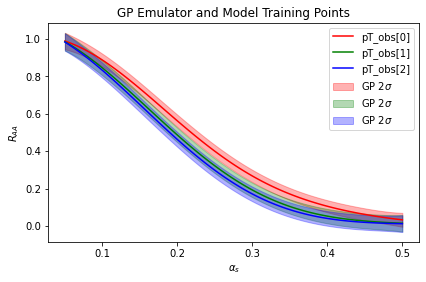

In [49]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
test_points = np.array([[x,true_values['exponent_inel'],
                 true_values['exponent_el'],true_values['scale_inel'],true_values['scale_el']] for x in np.linspace(prior_ranges['alpha_s'][0],prior_ranges['alpha_s'][1],n_plot_pts)])

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predict0(test_points)
gp_y1, gp_dy1 = emu_predict1(test_points)
gp_y2, gp_dy2 = emu_predict2(test_points)

plt.plot(test_points[:,0], gp_y0[:,0], color='red', label='pT_obs[0]')
plt.plot(test_points[:,0], gp_y1[:,0], color='green', label='pT_obs[1]')
plt.plot(test_points[:,0], gp_y2[:,0], color='blue', label='pT_obs[2]')
plt.fill_between(test_points[:,0], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')
plt.fill_between(test_points[:,0], y1 = gp_y1[:,0] - 2.*gp_dy1, y2 = gp_y1[:,0] + 2.*gp_dy1, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='green')
plt.fill_between(test_points[:,0], y1 = gp_y2[:,0] - 2.*gp_dy2, y2 = gp_y2[:,0] + 2.*gp_dy2, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='blue')

plt.xlabel(r'$\alpha_s$')
plt.ylabel(r'$R_{AA}$')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.tight_layout(True)

plt.show()

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


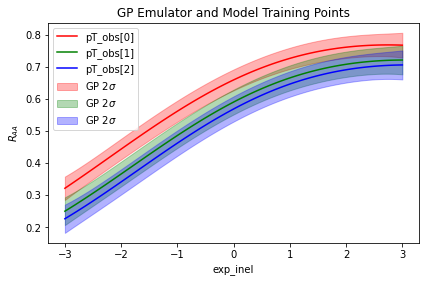

In [50]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
test_points = np.array([[true_values['alpha_s'],x,
                 true_values['exponent_el'],true_values['scale_inel'],true_values['scale_el']] for x in np.linspace(prior_ranges['exponent_inel'][0],prior_ranges['exponent_inel'][1],n_plot_pts)])

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predict0(test_points)
gp_y1, gp_dy1 = emu_predict1(test_points)
gp_y2, gp_dy2 = emu_predict2(test_points)

plt.plot(test_points[:,1], gp_y0[:,0], color='red', label='pT_obs[0]')
plt.plot(test_points[:,1], gp_y1[:,0], color='green', label='pT_obs[1]')
plt.plot(test_points[:,1], gp_y2[:,0], color='blue', label='pT_obs[2]')
plt.fill_between(test_points[:,1], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')
plt.fill_between(test_points[:,1], y1 = gp_y1[:,0] - 2.*gp_dy1, y2 = gp_y1[:,0] + 2.*gp_dy1, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='green')
plt.fill_between(test_points[:,1], y1 = gp_y2[:,0] - 2.*gp_dy2, y2 = gp_y2[:,0] + 2.*gp_dy2, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='blue')

plt.xlabel(r'exp_inel')
plt.ylabel(r'$R_{AA}$')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.tight_layout(True)

plt.show()

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


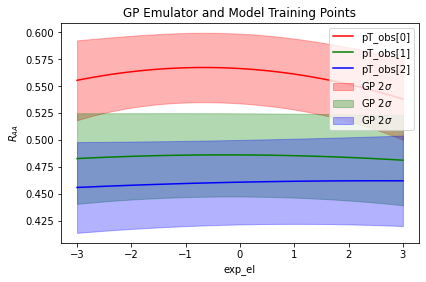

In [51]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
test_points = np.array([[true_values['alpha_s'],true_values['exponent_inel'],
                 x,true_values['scale_inel'],true_values['scale_el']] for x in np.linspace(prior_ranges['exponent_el'][0],prior_ranges['exponent_el'][1],n_plot_pts)])

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predict0(test_points)
gp_y1, gp_dy1 = emu_predict1(test_points)
gp_y2, gp_dy2 = emu_predict2(test_points)

plt.plot(test_points[:,2], gp_y0[:,0], color='red', label='pT_obs[0]')
plt.plot(test_points[:,2], gp_y1[:,0], color='green', label='pT_obs[1]')
plt.plot(test_points[:,2], gp_y2[:,0], color='blue', label='pT_obs[2]')
plt.fill_between(test_points[:,2], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')
plt.fill_between(test_points[:,2], y1 = gp_y1[:,0] - 2.*gp_dy1, y2 = gp_y1[:,0] + 2.*gp_dy1, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='green')
plt.fill_between(test_points[:,2], y1 = gp_y2[:,0] - 2.*gp_dy2, y2 = gp_y2[:,0] + 2.*gp_dy2, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='blue')

plt.xlabel(r'exp_el')
plt.ylabel(r'$R_{AA}$')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.tight_layout(True)

plt.show()

In [61]:
# Define the loglikelihood function
def logLikelihood(theta, x, obs, obserr):
  
    # Model parameters
    theta = np.array(theta)
    
    #alpha_s, mD_factor, exponent_inel, exponent_el = theta
    alpha_s, exp_inel, exp_el, sc_inel, sc_el = theta
    design = np.array([alpha_s, exp_inel, exp_el, sc_inel, sc_el]).reshape(1,-1)
    
    # Model predictions given parameters
    
    model = np.array([emu_predict0(design),emu_predict1(design),emu_predict2(design)],dtype=object)
    modelerr = model[:,1]
    model = model[:,0]
    
    # Likelihood of data given model parameters

    term2 = 0.5*(2*np.pi*np.sqrt(np.sum(obserr**2+modelerr.flatten()**2)))
    return -0.5*np.sum((obs.flatten()-model.flatten())**2/(obserr**2+modelerr.flatten()**2)) - term2

In [62]:
logLikelihood(truth.flatten(),x,obs,obserr)

-1.5570337346412972

In [63]:
# Define the logprior function
def logPrior(theta):
    
    # Model parameters
    theta = np.array(theta)
    alpha_s, exp_inel, exp_el, sc_inel, sc_el = theta 
    
    # Probability of model parameters: flat prior
    if prior_ranges['alpha_s'][0] < alpha_s < prior_ranges['alpha_s'][1] \
        and prior_ranges['exponent_inel'][0] < exp_inel < prior_ranges['exponent_inel'][1] \
        and prior_ranges['exponent_el'][0] < exp_el < prior_ranges['exponent_el'][1]\
        and prior_ranges['scale_inel'][0] < sc_inel < prior_ranges['scale_inel'][1] \
        and prior_ranges['scale_el'][0] < sc_el < prior_ranges['scale_el'][1]:
        return 0.0
    return -np.inf

In [64]:
# Define logprobability function: l(D|theta) * p(theta)
# Note: use this for emcee, not approxposterior!
def logposterior(theta, x, obs, obserr):
        
    lp = logPrior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logLikelihood(theta, x, obs, obserr)

In [65]:
ntemps = 25
Tmax = 1e3

nwalkers = 50 #guidance is 10*d
ndim = 5
nburnin = 2000
niterations= 5000
nthin = 1#0 # only record every nthin iteration

nthreads = 4

min_theta = np.array([prior_ranges['alpha_s'][0],prior_ranges['exponent_inel'][0],prior_ranges['exponent_el'][0],prior_ranges['scale_inel'][0],prior_ranges['scale_el'][0]])
max_theta = np.array([prior_ranges['alpha_s'][1],prior_ranges['exponent_inel'][1],prior_ranges['exponent_el'][1],prior_ranges['scale_inel'][1],prior_ranges['scale_el'][1]])

# Data and uncertainties that we use to condition our model
args = (x, obs, obserr) # recall x = np.array(pT_obs)

ptsampler=ptemcee.Sampler(nwalkers, ndim, logLikelihood, logPrior, ntemps, 
                  threads=nthreads, Tmax=Tmax, loglargs=args)

# Making the sampling multi-threaded is as simple as adding the threads=Nthreads 
# argument to PTSampler. 

# First, we run the sampler for 1000 burn-in iterations:
pos0 = np.random.uniform(min_theta, max_theta, (ntemps, nwalkers, ndim))

print("Running burn-in phase")
for p, lnprob, lnlike in ptsampler.sample(pos0, iterations=nburnin,adapt=True):
    pass
ptsampler.reset()

print("Running MCMC chains")
#Now we sample for nwalkers*niterations, recording every nthin-th sample:
for p, lnprob, lnlike in ptsampler.sample(p, iterations=niterations, thin=nthin,adapt=True):
    pass 

print('Done MCMC')

mean_acc_frac = np.mean(ptsampler.acceptance_fraction)
print(f"Mean acceptance fraction: {mean_acc_frac:.3f}",
      f"(in total {nwalkers*niterations} steps)")

Running burn-in phase
Running MCMC chains
Done MCMC
Mean acceptance fraction: 0.302 (in total 250000 steps)


In [66]:
chain = ptsampler.chain[0, :, :, :].reshape((-1, ndim))


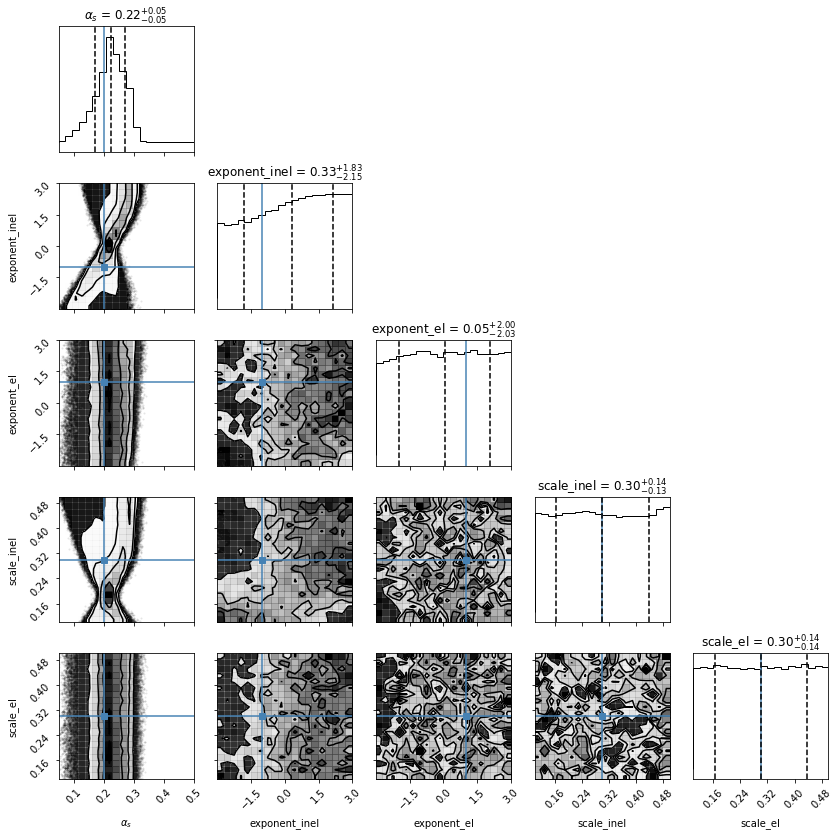

In [67]:
fig = corner.corner(chain, quantiles=[0.16, 0.5, 0.84], truths=truth.T,
                    labels=[r"$\alpha_s$", 'exponent_inel', 'exponent_el','scale_inel','scale_el'], show_titles=True, scale_hist=True,
                    plot_contours=True, range=(prior_ranges.values()));
plt.tight_layout()
plt.savefig('corner-lhsgp-ptemcee.png',dpi=600)
plt.show()